In [15]:
import os.path as path
from pyspark.sql import SparkSession
from pyspark.sql import column
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer, VectorAssembler,OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier

In [16]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [17]:
import nltk
import os

# Set the custom download path for NLTK data
custom_download_path = '/'

# Make sure the directory exists; if not, create it
os.makedirs(custom_download_path, exist_ok=True)

# Append the custom download path to NLTK data path
nltk.data.path.append(custom_download_path)

# Download NLTK resources to the custom path
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/umang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/umang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/umang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [47]:
stopword = set(stopwords.words('english'))


In [48]:
def preprocessing(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation using regular expressions
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove specific characters #, @, and $
    text = re.sub(r'[#@\$]', '', text)
    
    # tokenize and convert to list
    tokens = word_tokenize(text)
    
    ## Lemmatize it 
    lemmatizer  = WordNetLemmatizer()
    
    ## lemmatize each token
   # text = [lemmatizer.lemmatize(token) for token in tokens]
    text = text.split()
    
    text = [word for word in text if word not in stopword]
    
    
    return " ".join(text) 
   
 

In [19]:
def init_spark():
  return SparkSession \
        .builder \
        .appName("Big data project") \
        .config("spark.executor.memory", "8g") \
        .config("spark.driver.memory", "8g") \
        .getOrCreate()

spark = init_spark()

24/03/28 18:15:46 WARN Utils: Your hostname, DESKTOP-968IKC4 resolves to a loopback address: 127.0.1.1; using 172.31.102.226 instead (on interface eth0)
24/03/28 18:15:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/28 18:15:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/03/28 18:15:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [34]:
def get_data_dataframe(dir="final_dataset.csv"):
    # Specify the directory where the CSV files are saved
    csv_directory = dir
    
    # Read the CSV files back into a DataFrame
    final_df_read = spark.read.option("header", "true").csv(csv_directory)
    
    # Add a random column to shuffle data randomly
    shuffled_df = final_df_read.withColumn("rand", rand())
    shuffled_df = shuffled_df.orderBy("rand")
    final_df_read = shuffled_df.drop("rand")
    return final_df_read



In [35]:
def print_class_distribution(df):
    # Group the DataFrame by the "genre" column and count the occurrences of each genre
    genre_counts = df.groupBy("genre").count()
    
    # Show the genre counts
    genre_counts.show()

# Replacing Null Values With Zero

In [36]:
def show_null_values_distribution(train_df):
    null_value_list = list()
    for col_ in train_df.columns:
        null_value_list.append(train_df.filter(train_df[col_]=="\\N").count())                     
    plt.rcParams["figure.figsize"] = (10,6)
    columns = [col_ for col_ in train_df.columns]
    
    plt.figure(figsize=(10, 6))
    plt.bar(columns, null_value_list, color='skyblue')
    plt.xlabel('Columns')
    plt.ylabel('Number of Null Values')
    plt.ylim(0, train_df.count())
    plt.title('Distribution of Null Values in Columns')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Drop Duplicates

In [75]:
def drop_duplicates(train_df):
    print(train_df.count())
    train_df=train_df.dropDuplicates()
    print(train_df.count())

In [154]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


final_df_read=get_data_dataframe("final_dataset_with_df2.csv")
print_class_distribution(final_df_read)
# df = final_df_read.toPandas()

# # Combine data from all columns into a single feature column
# df['combined_text'] = df['title'] + ' ' + df['director'] + ' ' + df['writer'] + ' ' + df['actor1'] + ' ' + df['actor2'] + ' ' + df['actor3'] + ' ' + df['actor4'] + ' ' + df['plot']

# # Initialize TF-IDF vectorizer
# tfidf_vectorizer = TfidfVectorizer()

# # Fit and transform the combined text using TF-IDF vectorizer
# X = tfidf_vectorizer.fit_transform(df['combined_text'])



+------+-----+
| genre|count|
+------+-----+
| Drama| 4064|
|Horror| 1176|
|Comedy| 2951|
|Action| 2738|
+------+-----+



In [119]:
# Define target variable
y = df['genre']  # Specify the target column for classification

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=500, max_depth=50, min_samples_split=50, min_samples_leaf=50, random_state=42)



In [122]:

rf_classifier.fit(X_train,y_train)


RandomForestClassifier(max_depth=50, min_samples_leaf=50, min_samples_split=50,
                       n_estimators=500, random_state=42)

In [123]:
y_pred = rf_classifier.predict(X_test)


In [127]:
y_test

1964     Action
8285     Comedy
3891      Drama
1703     Comedy
10879     Drama
          ...  
2970      Drama
10704    Comedy
8975      Drama
4414     Horror
4838     Comedy
Name: genre, Length: 3279, dtype: object

In [129]:
y_pred.size

3279

In [131]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      Action       0.70      0.10      0.17       811
      Comedy       0.00      0.00      0.00       894
       Drama       0.38      0.99      0.55      1230
      Horror       0.00      0.00      0.00       344

    accuracy                           0.39      3279
   macro avg       0.27      0.27      0.18      3279
weighted avg       0.32      0.39      0.25      3279



/home/umang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/umang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/umang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [132]:
final_df_read=get_data_dataframe("final_dataset_with_df2.csv")

df=final_df_read

In [133]:
final_df_read.head()

Row(title='The Last Time I Saw Paris', year='1954', runtime='116', genre='Drama', rating='6.1', director='Richard Brooks', writer='Julius J. Epstein', actor1='Kurt Kasznar', actor2='Van Johnson', actor3='George Dolenz', actor4='Roger Moore', plot="As World War II ends in Europe, Stars and Stripes journalist Charles Wills (Van Johnson) is on the streets of Paris, covering the celebrations. He is suddenly grabbed by a beautiful woman, who kisses him and disappears. Charles follows the crowd to Café Dhingo and meets another pretty woman named Marion Ellswirth (Donna Reed). The mutual attraction is instant and she invites him to join her father's celebration of the end of the war in Europe. Charles, Marion and her persistent French suitor Claude Matine (George Dolenz) arrive at the Ellswirth household, and we find that the woman who had kissed Charles is Marion's younger sister Helen (Elizabeth Taylor).", tags=None, split=None, synopsis_source=None)

In [134]:
preprocessing_udf = udf(preprocessing, StringType())


In [135]:
df=final_df_read
df = df.withColumn("plot_clean", preprocessing_udf(df["plot"]))


In [136]:
df.head()

Row(title='The Last Time I Saw Paris', year='1954', runtime='116', genre='Drama', rating='6.1', director='Richard Brooks', writer='Julius J. Epstein', actor1='Kurt Kasznar', actor2='Van Johnson', actor3='George Dolenz', actor4='Roger Moore', plot="As World War II ends in Europe, Stars and Stripes journalist Charles Wills (Van Johnson) is on the streets of Paris, covering the celebrations. He is suddenly grabbed by a beautiful woman, who kisses him and disappears. Charles follows the crowd to Café Dhingo and meets another pretty woman named Marion Ellswirth (Donna Reed). The mutual attraction is instant and she invites him to join her father's celebration of the end of the war in Europe. Charles, Marion and her persistent French suitor Claude Matine (George Dolenz) arrive at the Ellswirth household, and we find that the woman who had kissed Charles is Marion's younger sister Helen (Elizabeth Taylor).", tags=None, split=None, synopsis_source=None, plot_clean='world war ii ends europe sta

In [137]:
genres= ["Drama", "Comedy", "Horror", "Action"]

# Aggregate descriptions by genre
grouped_df = df.groupBy("genre").agg(collect_list("plot_clean").alias("plot_clean"))

# Convert to Pandas DataFrame for word cloud generation
pandas_grouped_df = grouped_df.toPandas()



In [138]:
pandas_grouped_df

,genre,plot_clean
0,Drama,[world war ii ends europe stars stripes journa...
1,Horror,[undead serial killer jason voorhees returns c...
2,Comedy,[mothers death vincent robert sheehan teenager...
3,Action,[colonel suryaveer surya singh amitabh bachcha...


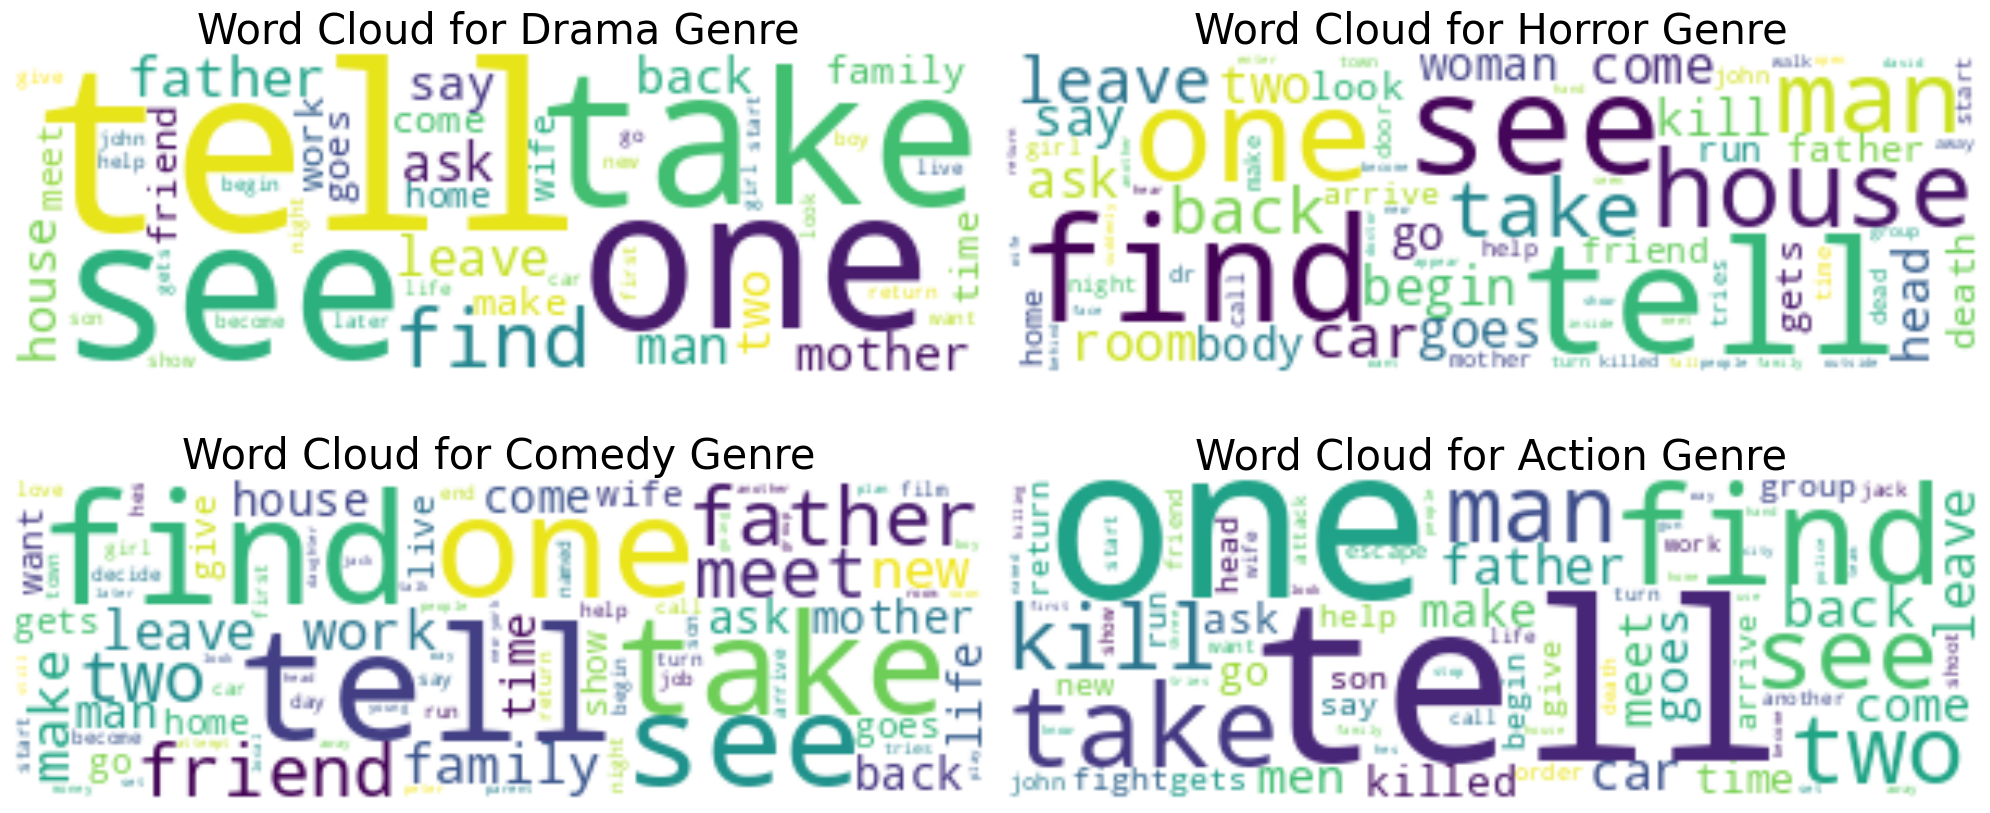

In [139]:
# Set the figure size outside the loop
plt.figure(figsize=(20, 60))

# Iterate over each genre
for i, row in pandas_grouped_df.iterrows():
    genre = row["genre"]
    plt.subplot(14, 2, i+1)  # Assuming you have 14 rows and 2 columns for 28 genres
    text_subset = " ".join(row["plot_clean"])
    wordcloud = WordCloud(max_words=300, width=300, height=100, background_color='white').generate(text_subset)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {genre} Genre', fontsize=30)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [140]:
df=df.drop("synopsis_source","split","tags","rating","runtime","year")

In [141]:
df


DataFrame[title: string, genre: string, director: string, writer: string, actor1: string, actor2: string, actor3: string, actor4: string, plot: string, plot_clean: string]

In [142]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

In [143]:
# Tokenization, stop word removal, and TF-IDF transformation for text data
tokenizer = RegexTokenizer(inputCol="plot", outputCol="words", pattern="\\W")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="raw_features")
idf = IDF(inputCol="raw_features", outputCol="plot_features")



In [83]:
# Encoding genre labels
genre_indexer = StringIndexer(inputCol="genre", outputCol="label")

In [101]:

# Encoding categorical variables: director, writer, actor1, actor2, actor3, actor4
director_indexer = StringIndexer(inputCol="director", outputCol="director_index", handleInvalid="keep")
writer_indexer = StringIndexer(inputCol="writer", outputCol="writer_index", handleInvalid="keep")
actor1_indexer = StringIndexer(inputCol="actor1", outputCol="actor1_index", handleInvalid="keep")
actor2_indexer = StringIndexer(inputCol="actor2", outputCol="actor2_index", handleInvalid="keep")
actor3_indexer = StringIndexer(inputCol="actor3", outputCol="actor3_index", handleInvalid="keep")
actor4_indexer = StringIndexer(inputCol="actor4", outputCol="actor4_index", handleInvalid="keep")

# One-hot encode categorical variables
director_encoder = OneHotEncoder(inputCol="director_index", outputCol="director_vec")
writer_encoder = OneHotEncoder(inputCol="writer_index", outputCol="writer_vec")
actor1_encoder = OneHotEncoder(inputCol="actor1_index", outputCol="actor1_vec")
actor2_encoder = OneHotEncoder(inputCol="actor2_index", outputCol="actor2_vec")
actor3_encoder = OneHotEncoder(inputCol="actor3_index", outputCol="actor3_vec")
actor4_encoder = OneHotEncoder(inputCol="actor4_index", outputCol="actor4_vec")


In [144]:
# Assemble features
assembler = VectorAssembler(inputCols=["plot_features", "director_vec", "writer_vec",
                                       "actor1_vec", "actor2_vec", "actor3_vec", "actor4_vec"],
                            outputCol="features")

# Define the Random Forest classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="plot_features", numTrees=50)


In [145]:
# pipeline = Pipeline(stages=[tokenizer,remover,vectorizer, idf, genre_indexer,
#                             director_indexer, writer_indexer,
#                             actor1_indexer, actor2_indexer, actor3_indexer, actor4_indexer,
#                             director_encoder, writer_encoder,
#                             actor1_encoder, actor2_encoder, actor3_encoder, actor4_encoder,
#                             assembler, rf])
pipeline = Pipeline(stages=[tokenizer,remover,vectorizer, idf, genre_indexer,
                            rf])

In [146]:
# Split the data into training and testing sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Show the number of rows in each set
print("Training set count:", train_df.count())
print("Testing set count:", test_df.count())

Training set count: 8765


Testing set count: 2164


In [147]:
# Train the model
model = pipeline.fit(train_df)

# Make predictions
# predictions = model.transform(test_df)

24/03/28 19:47:00 WARN DAGScheduler: Broadcasting large task binary with size 1521.4 KiB
24/03/28 19:47:01 WARN DAGScheduler: Broadcasting large task binary with size 1521.5 KiB
24/03/28 19:47:02 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/03/28 19:47:10 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/03/28 19:47:13 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/03/28 19:47:14 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/03/28 19:47:14 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/03/28 19:47:15 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


In [148]:
predictions = model.transform(test_df)

In [149]:
predictions

DataFrame[title: string, genre: string, director: string, writer: string, actor1: string, actor2: string, actor3: string, actor4: string, plot: string, plot_clean: string, words: array<string>, filtered_words: array<string>, raw_features: vector, plot_features: vector, label: double, rawPrediction: vector, probability: vector, prediction: double]

In [150]:
predictions.select("genre","prediction").head()

24/03/28 19:47:50 WARN DAGScheduler: Broadcasting large task binary with size 1763.6 KiB


Row(genre='Drama', prediction=0.0)

In [151]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

24/03/28 19:47:54 WARN DAGScheduler: Broadcasting large task binary with size 1784.2 KiB


Accuracy: 0.4108133086876155


In [152]:


def print_statistis(predictions):

    # Compute raw scores on the test set
    predictionAndLabels = predictions.rdd.map(lambda lp: (lp.prediction, lp.label))
    
    # Instantiate metrics object
    metrics = MulticlassMetrics(predictionAndLabels)
    confusion_matrix = metrics.confusionMatrix().toArray()
    
    # Overall statistics
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1Score = metrics.fMeasure(1.0)
    total_predictions = confusion_matrix.sum(axis=1)
    print("Summary Stats")
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1Score)
    
    # Statistics by class
    labels = predictions.rdd.map(lambda lp: lp.label).distinct().collect()
    accuracies = {}
    for label in sorted(labels):
        # print("______________________"+mapping[label]+"_____________________")
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
        
    
    # Calculate the accuracy for each label
    print(total_predictions)
    for label in range(len(total_predictions)):
        correct_predictions = confusion_matrix[label, label]
        accuracy = correct_predictions / total_predictions[label]
        accuracies[label] = accuracy
    
    # Print accuracies for each label
    for label, accuracy in accuracies.items():
        print("Accuracy for label %s: %s" % (label, accuracy))


In [153]:
print_statistis(predictions)

/home/umang/.local/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/03/28 19:48:02 WARN DAGScheduler: Broadcasting large task binary with size 1807.1 KiB
24/03/28 19:48:03 WARN DAGScheduler: Broadcasting large task binary with size 1818.0 KiB
24/03/28 19:48:05 WARN DAGScheduler: Broadcasting large task binary with size 1810.7 KiB


Summary Stats
Precision = 0.0
Recall = 0.0
F1 Score = 0.0


Class 0.0 precision = 0.4
Class 0.0 recall = 0.9882075471698113
Class 0.0 F1 Measure = 0.5694869181107715
Class 1.0 precision = 0.0
Class 1.0 recall = 0.0
Class 1.0 F1 Measure = 0.0
Class 2.0 precision = 0.7391304347826086
Class 2.0 recall = 0.09586466165413533
Class 2.0 F1 Measure = 0.1697171381031614
Class 3.0 precision = 0.0
Class 3.0 recall = 0.0
Class 3.0 F1 Measure = 0.0
[848. 571. 532. 213.]
Accuracy for label 0: 0.9882075471698113
Accuracy for label 1: 0.0
Accuracy for label 2: 0.09586466165413533
Accuracy for label 3: 0.0


In [115]:
predictionAndLabels = predictions.select("prediction", "label").rdd

# Instantiate MulticlassMetrics
metrics = MulticlassMetrics(predictionAndLabels)

# Calculate the confusion matrix
confusion_matrix = metrics.confusionMatrix()

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix)

24/03/28 19:33:02 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
24/03/28 19:33:03 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


Confusion Matrix:
DenseMatrix([[842.,   0.,   6.,   0.],
             [567.,   0.,   4.,   0.],
             [488.,   0.,  44.,   0.],
             [209.,   0.,   4.,   0.]])


In [109]:
def print_and_return_mapping_of_index_to_label(df,predicting='genre'):
    # Collect distinct pairs of (label, genre)
    label_genre_mapping = df.select("label", predicting).distinct().collect()
    map={}
    # Print the mapping
    for mapping in label_genre_mapping:
        print("Label %s is mapped to genre '%s'" % (mapping.label, mapping.genre))
        map[mapping.label]= mapping.genre
    return map

PipelineModel_e071f1bf6981

# Normalization

In [39]:
def get_stages_of_normalization(categoricalColumns =['title',
     'director',
     'writer',
     'actorPrimaryName'], predicting='genre'):
    stages = []
    for categoricalCol in categoricalColumns:
        stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
        # encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
        stages += [stringIndexer]
    label_stringIdx = StringIndexer(inputCol = predicting, outputCol = 'label')
    stages += [label_stringIdx]
    
    assemblerInputs = [c + "Index" for c in categoricalColumns] 
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    stages += [assembler]
    return stages

In [40]:

def get_normalized_data(df):
    pipeline = Pipeline(stages = stages)
    pipelineModel = pipeline.fit(df)
    final_df_read = pipelineModel.transform(df)
    selectedCols = ['label', 'features','genre']+['title',
     'director',
     'writer',
     'actorPrimaryName']
    final_df_read = final_df_read.select(selectedCols)
    final_df_read.printSchema()
    return final_df_read

# Utils

In [41]:
def print_and_return_mapping_of_index_to_label(df,predicting='genre'):
    # Collect distinct pairs of (label, genre)
    label_genre_mapping = df.select("label", predicting).distinct().collect()
    map={}
    # Print the mapping
    for mapping in label_genre_mapping:
        print("Label %s is mapped to genre '%s'" % (mapping.label, mapping.genre))
        map[mapping.label]= mapping.genre
    return map

# Train and Test

In [42]:
final_df_read=get_data_dataframe()



In [43]:
stages=get_stages_of_normalization()
final_df_read=get_normalized_data(final_df_read)

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- genre: string (nullable = true)
 |-- title: string (nullable = true)
 |-- director: string (nullable = true)
 |-- writer: string (nullable = true)
 |-- actorPrimaryName: string (nullable = true)



In [44]:
# Split the data into training and testing sets
train_df, test_df = final_df_read.randomSplit([0.8, 0.2], seed=42)

# Show the number of rows in each set
print("Training set count:", train_df.count())
print("Testing set count:", test_df.count())

24/03/20 17:23:24 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


Training set count: 32011


24/03/20 17:23:25 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


Testing set count: 7989


In [45]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxBins=60000)
dtModel = dt.fit(train_df)

24/03/20 17:23:27 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/03/20 17:23:27 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/03/20 17:23:27 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 60000 to 32011 (= number of training instances)
24/03/20 17:23:27 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/03/20 17:23:31 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/03/20 17:23:38 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/03/20 17:23:51 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/03/20 17:24:16 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


In [46]:
predictions = dtModel.transform(test_df)
predictions.show(10)

24/03/20 17:25:32 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


+-----+--------------------+-----+--------+------------------+------------------+--------------------+--------------------+--------------------+----------+
|label|            features|genre|   title|          director|            writer|    actorPrimaryName|       rawPrediction|         probability|prediction|
+-----+--------------------+-----+--------+------------------+------------------+--------------------+--------------------+--------------------+----------+
|  0.0|[1.0,2234.0,2010....|Drama|    Vera|  Nedeljko Kovacic| Kristina Djukovic|         Nikola Kojo|[221.0,23.0,67.0,...|[0.68847352024922...|       0.0|
|  0.0|[1.0,4372.0,4393....|Drama|    Vera|   Steffy Argelich|   Steffy Argelich|        John Steiner|[221.0,23.0,67.0,...|[0.68847352024922...|       0.0|
|  0.0|[1.0,4372.0,4393....|Drama|    Vera|   Steffy Argelich|   Steffy Argelich|María Jose Gil Go...|[221.0,23.0,67.0,...|[0.68847352024922...|       0.0|
|  0.0|[2.0,2266.0,2216....|Drama| Breathe|      Onur Karaman|  

# Evaluation

In [52]:


def print_statistis(predictions,mapping):

    # Compute raw scores on the test set
    predictionAndLabels = predictions.rdd.map(lambda lp: (lp.prediction, lp.label))
    
    # Instantiate metrics object
    metrics = MulticlassMetrics(predictionAndLabels)
    confusion_matrix = metrics.confusionMatrix().toArray()
    
    # Overall statistics
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1Score = metrics.fMeasure(1.0)
    total_predictions = confusion_matrix.sum(axis=1)
    print("Summary Stats")
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1Score)
    
    # Statistics by class
    labels = predictions.rdd.map(lambda lp: lp.label).distinct().collect()
    accuracies = {}
    for label in sorted(labels):
        print("______________________"+mapping[label]+"_____________________")
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
        
    
    # Calculate the accuracy for each label
    print(total_predictions)
    for label in range(len(total_predictions)):
        correct_predictions = confusion_matrix[label, label]
        accuracy = correct_predictions / total_predictions[label]
        accuracies[label] = accuracy
    
    # Print accuracies for each label
    for label, accuracy in accuracies.items():
        print("Accuracy for label %s: %s" % (label, accuracy))


In [53]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Accuracy: {accuracy:.2f}")

24/03/20 17:29:54 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


Test Accuracy: 0.40


In [54]:
mapp=print_and_return_mapping_of_index_to_label(train_df)

Label 0.0 is mapped to genre 'Drama'
Label 1.0 is mapped to genre 'Comedy'
Label 2.0 is mapped to genre 'Action'
Label 3.0 is mapped to genre 'Horror'
Label 4.0 is mapped to genre 'Thriller'
Label 5.0 is mapped to genre 'Romance'


24/03/20 17:29:57 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


In [55]:
print_statistis(predictions,mapp)

/home/umang/.local/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/03/20 17:29:58 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/03/20 17:29:58 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/03/20 17:31:03 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


Summary Stats
Precision = 0.3426724137931034
Recall = 0.14058355437665782
F1 Score = 0.19937304075235107


______________________Drama_____________________
Class 0.0 precision = 0.4054972661445249
Class 0.0 recall = 0.9137529137529138
Class 0.0 F1 Measure = 0.5617195496417605
______________________Comedy_____________________
Class 1.0 precision = 0.3426724137931034
Class 1.0 recall = 0.14058355437665782
Class 1.0 F1 Measure = 0.19937304075235107
______________________Action_____________________
Class 2.0 precision = 0.5238095238095238
Class 2.0 recall = 0.11412609736632083
Class 2.0 F1 Measure = 0.1874180865006553
______________________Horror_____________________
Class 3.0 precision = 0.7619047619047619
Class 3.0 recall = 0.02069857697283312
Class 3.0 F1 Measure = 0.04030226700251889
______________________Thriller_____________________
Class 4.0 precision = 0.0
Class 4.0 recall = 0.0
Class 4.0 F1 Measure = 0.0
______________________Romance_____________________
Class 5.0 precision = 0.0
Class 5.0 recall = 0.0
Class 5.0 F1 Measure = 0.0
[3003. 2262. 1253.  773.  545.  153.]
Accuracy for label 